<h1>Define Health by Age<h1>

@syahrulmwijaya

<h3>Importing all needed packages</h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from fancyimpute import IterativeImputer

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import random
random.seed(42)

In [3]:
df = pd.read_csv("datasets/ICR/train.csv")
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
greeks = pd.read_csv("datasets/ICR/greeks.csv")
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [5]:
test = pd.read_csv("datasets/ICR/test.csv")
test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
per80 = int(0.8*(len(df)))
valid = df.iloc[per80:]
df = df.iloc[:per80]


In [7]:
valid

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
493,c7f5064f4265,0.132463,3010.64577,85.200147,8.857420,8.138688,5.253387,0.025578,3.396778,1.229900,...,10.499370,2.12802,0.386061,23.571268,72.611063,2081.341656,13.886772,70.748004,0.136759,1
494,c809ac237df8,0.636677,3836.39454,87.730112,42.466064,8.138688,3.038637,0.025578,11.457036,2.572248,...,10.816877,1.87833,0.067730,18.408658,72.611063,3533.304078,28.048898,31.118628,0.041704,1
495,c82e5a429e5b,0.491395,2773.45431,85.200147,13.759971,8.138688,3.658767,0.026187,14.116480,1.229900,...,2.401359,0.49706,0.291239,15.683172,85.921693,871.335792,37.537448,105.601176,0.353189,0
496,c86be787cb28,0.235015,2938.09538,166.890567,37.427245,8.138688,6.883443,0.025578,22.951884,8.257900,...,0.173229,1.18378,0.575705,14.594838,72.611063,34299.797000,30.534526,11.694884,21.978000,0
497,c8a5264f7458,1.012701,2962.87376,119.313300,46.402351,8.138688,11.206635,0.025578,21.836430,5.123412,...,0.173229,0.49706,1.002404,32.687228,147.982751,68219.445290,34.422971,59.464640,21.978000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


<h2>Data Preprocessing</h2>

In [8]:
to_drop = 'Id'
df = df[[column for column in df.columns if column not in [to_drop]]]

In [9]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      493 non-null    float64
 1   AF      493 non-null    float64
 2   AH      493 non-null    float64
 3   AM      493 non-null    float64
 4   AR      493 non-null    float64
 5   AX      493 non-null    float64
 6   AY      493 non-null    float64
 7   AZ      493 non-null    float64
 8   BC      493 non-null    float64
 9   BD      493 non-null    float64
 10  BN      493 non-null    float64
 11  BP      493 non-null    float64
 12  BQ      448 non-null    float64
 13  BR      493 non-null    float64
 14  BZ      493 non-null    float64
 15  CB      491 non-null    float64
 16  CC      490 non-null    float64
 17  CD      493 non-null    float64
 18  CF      493 non-null    float64
 19  CH      493 non-null    float64
 20  CL      493 non-null    float64
 21  CR      493 non-null    float64
 22  CS

In [10]:
print(df.shape, test.shape)

(493, 57) (5, 57)


In [11]:
for column in df.columns:
    if df[column].isna().any():
        print(f"{column} contains {df[column].isna().sum()} missing values")

BQ contains 45 missing values
CB contains 2 missing values
CC contains 3 missing values
EL contains 47 missing values
FC contains 1 missing values
FS contains 1 missing values


In [20]:
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data = imputer.fit_transform(df[[column for column in df.columns if column not in ['Id', 'EJ', 'Class']]])
new_df = pd.DataFrame(imputed_data, columns=[column for column in df.columns if column not in ['Id', 'EJ', 'Class']])
new_df['EJ'], new_df['Class'] = df['EJ'], df['Class']
new_df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,B,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,A,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,B,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,B,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,B,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,0.247834,2925.54768,85.200147,25.565735,8.138688,4.704129,0.025578,3.396778,1.229900,7065.14152,...,1.22235,0.541840,19.459784,72.611063,28431.621110,26.839573,26.805384,0.133562,B,0
489,0.371751,2072.22301,120.532560,5.373295,8.138688,4.296615,0.041716,17.544768,1.229900,8124.49567,...,0.49706,0.162552,42.119456,72.611063,8206.925265,25.060935,9.210332,0.222930,B,0
490,0.474303,4877.54146,85.200147,34.996100,8.138688,5.864658,0.025578,3.396778,5.081244,3877.09956,...,1.07764,0.535067,23.106168,72.611063,2497.724586,42.534751,19.323436,0.048712,B,1
491,0.290564,4875.39734,85.200147,20.762288,8.138688,4.686411,0.025578,9.005558,10.647420,3906.20713,...,1.17798,0.067730,21.850398,72.611063,3580.530156,19.587344,39.259008,0.231000,B,0


In [24]:
new_df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,B,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,A,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,B,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,B,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,B,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,0.247834,2925.54768,85.200147,25.565735,8.138688,4.704129,0.025578,3.396778,1.229900,7065.14152,...,1.22235,0.541840,19.459784,72.611063,28431.621110,26.839573,26.805384,0.133562,B,0
489,0.371751,2072.22301,120.532560,5.373295,8.138688,4.296615,0.041716,17.544768,1.229900,8124.49567,...,0.49706,0.162552,42.119456,72.611063,8206.925265,25.060935,9.210332,0.222930,B,0
490,0.474303,4877.54146,85.200147,34.996100,8.138688,5.864658,0.025578,3.396778,5.081244,3877.09956,...,1.07764,0.535067,23.106168,72.611063,2497.724586,42.534751,19.323436,0.048712,B,1
491,0.290564,4875.39734,85.200147,20.762288,8.138688,4.686411,0.025578,9.005558,10.647420,3906.20713,...,1.17798,0.067730,21.850398,72.611063,3580.530156,19.587344,39.259008,0.231000,B,0


In [27]:
for column in new_df.columns:
    if new_df[column].dtype == 'object':
        print(new_df[column].value_counts())

EJ
B    320
A    173
Name: count, dtype: int64


In [28]:
encoder_list = {}
clear_df = new_df.copy()
for column in clear_df.columns:
    if clear_df[column].dtype == 'object':
        print(column)
        encoder = OneHotEncoder(sparse=False, drop=None)
        
        test_encoder = pd.DataFrame()
        test_encoder[column] = clear_df[column].copy()
        encoder_list[column] = encoder.fit(test_encoder)
        encoded_data = encoder.transform(test_encoder)

        result = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out()).astype(int)
        clear_df = pd.concat([clear_df, result], axis=1)
        clear_df.drop(column, axis=1, inplace=True)

encoder_list
        

EJ


c:\Users\LENOVO\anaconda3\envs\datascience\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'EJ': OneHotEncoder(sparse=False, sparse_output=False)}

In [29]:
clear_df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FS,GB,GE,GF,GH,GI,GL,Class,EJ_A,EJ_B
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,1
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,1
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,0.247834,2925.54768,85.200147,25.565735,8.138688,4.704129,0.025578,3.396778,1.229900,7065.14152,...,0.541840,19.459784,72.611063,28431.621110,26.839573,26.805384,0.133562,0,0,1
489,0.371751,2072.22301,120.532560,5.373295,8.138688,4.296615,0.041716,17.544768,1.229900,8124.49567,...,0.162552,42.119456,72.611063,8206.925265,25.060935,9.210332,0.222930,0,0,1
490,0.474303,4877.54146,85.200147,34.996100,8.138688,5.864658,0.025578,3.396778,5.081244,3877.09956,...,0.535067,23.106168,72.611063,2497.724586,42.534751,19.323436,0.048712,1,0,1
491,0.290564,4875.39734,85.200147,20.762288,8.138688,4.686411,0.025578,9.005558,10.647420,3906.20713,...,0.067730,21.850398,72.611063,3580.530156,19.587344,39.259008,0.231000,0,0,1


<Axes: xlabel='Class'>

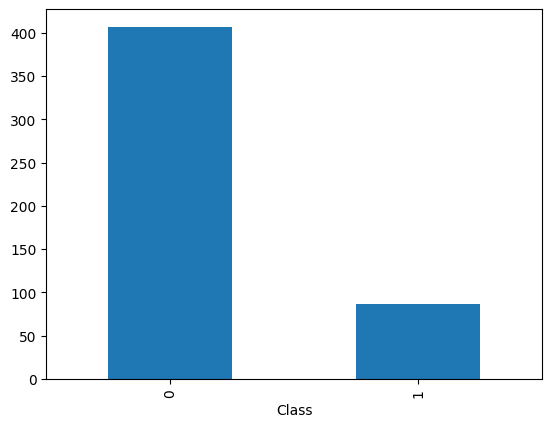

In [30]:
side_unique = clear_df['Class'].value_counts()
side_unique.plot.bar()

In [31]:
target = 'Class'
X = clear_df[[column for column in clear_df.columns if column not in [target]]]
y = clear_df[target]

In [32]:
X

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,0,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,1,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,0.247834,2925.54768,85.200147,25.565735,8.138688,4.704129,0.025578,3.396778,1.229900,7065.14152,...,1.22235,0.541840,19.459784,72.611063,28431.621110,26.839573,26.805384,0.133562,0,1
489,0.371751,2072.22301,120.532560,5.373295,8.138688,4.296615,0.041716,17.544768,1.229900,8124.49567,...,0.49706,0.162552,42.119456,72.611063,8206.925265,25.060935,9.210332,0.222930,0,1
490,0.474303,4877.54146,85.200147,34.996100,8.138688,5.864658,0.025578,3.396778,5.081244,3877.09956,...,1.07764,0.535067,23.106168,72.611063,2497.724586,42.534751,19.323436,0.048712,0,1
491,0.290564,4875.39734,85.200147,20.762288,8.138688,4.686411,0.025578,9.005558,10.647420,3906.20713,...,1.17798,0.067730,21.850398,72.611063,3580.530156,19.587344,39.259008,0.231000,0,1


In [33]:
y

0      1
1      0
2      0
3      0
4      1
      ..
488    0
489    0
490    1
491    0
492    0
Name: Class, Length: 493, dtype: int64

In [34]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

<Axes: xlabel='Class'>

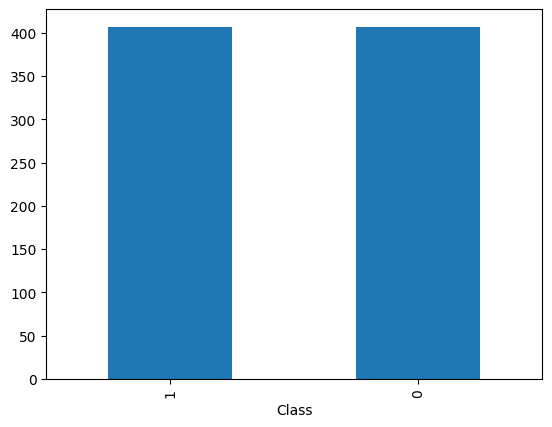

In [36]:
side_unique = y_resampled.value_counts()
side_unique.plot.bar()

<h2>Model Making</h2>

In [37]:
valid.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [38]:
class Ensemble():
    def __init__(self):
        self.target = 'Class'
        self.to_drop = 'Id'
        self.imputer = encoder_list
        params_xgb = {"learning_rate":0.001,
           "max_depth":3,
           "n_estimators":4000,
           'eval_metric': 'auc',
           'booster': 'gbtree',
           'max_depth' : 12}
        
        params_lgb = {
            'boosting_type': 'GBDT',
            'random_state': 42,
            'verbose': -1
        }

        self.classifiers = [
            XGBClassifier(**params_xgb),
            LGBMClassifier(**params_lgb),
            LogisticRegression(max_iter=200),
            CatBoostClassifier(random_seed=42, verbose=100, iterations=1000) 
            
        ]
    
    def fit(self, X, y):
        for classifier in self.classifiers:
            classifier.fit(X, y)
     
    def predict_proba(self, df):
        #df = df.dropna()
        clear_df = df.copy()
        try:
            clear_df = clear_df.drop(self.to_drop, axis=1)
        except Exception:
            pass
        for column in clear_df.columns:
            if clear_df[column].dtype == 'object':
                encoder = self.imputer[column]
                test_encoder = pd.DataFrame()
                test_encoder[column] = clear_df[column].copy()
                encoded_data = encoder.transform(test_encoder)
                result = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out()).astype(int)
                clear_df = pd.concat([clear_df.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
                clear_df.drop(column, axis=1, inplace=True)
                print(clear_df)

        x = clear_df[[column for column in clear_df.columns if column not in [self.target]]]
        x = x.dropna()
        
        probabilities = np.stack([classifier.predict_proba(x) for classifier in self.classifiers])
        averaged_probabilities = np.mean(probabilities, axis=0)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()

        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)

In [39]:
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

In [40]:
def training(model, x, y):
    outer_results = list()
    best_loss = np.inf
    split = 0
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx,val_idx in skf.split(x,y):
        x_train, x_val = x.iloc[train_idx],x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_val)
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
        p0 = probabilities[:,:1]
        
        y_p = np.empty((y_pred.shape[0],))
        for i in range(y_pred.shape[0]):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        y_p = y_p.astype(int)
        loss = balanced_log_loss(y_val,y_p)

        if loss<best_loss:
            best_model = model
            best_loss = loss
            print('best_model_saved')
        outer_results.append(loss)
        print('>val_loss=%.5f, split = %.1f' % (loss,split))
    print('LOSS: %.5f' % (np.mean(outer_results)))
    return best_model


In [70]:
yt = Ensemble()
m = training(yt,X, y)

c:\Users\LENOVO\anaconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.006922
0:	learn: 0.6846558	total: 21.7ms	remaining: 21.7s
100:	learn: 0.2983912	total: 985ms	remaining: 8.77s
200:	learn: 0.1794104	total: 1.91s	remaining: 7.6s
300:	learn: 0.1230377	total: 2.83s	remaining: 6.56s
400:	learn: 0.0907534	total: 3.69s	remaining: 5.51s
500:	learn: 0.0692961	total: 4.7s	remaining: 4.68s
600:	learn: 0.0544009	total: 5.53s	remaining: 3.67s
700:	learn: 0.0440004	total: 6.45s	remaining: 2.75s
800:	learn: 0.0356141	total: 7.24s	remaining: 1.8s
900:	learn: 0.0291930	total: 8.08s	remaining: 888ms
999:	learn: 0.0238805	total: 8.97s	remaining: 0us
best_model_saved
>val_loss=1.58583, split = 0.0


c:\Users\LENOVO\anaconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.006922
0:	learn: 0.6862501	total: 20.9ms	remaining: 20.9s
100:	learn: 0.3071137	total: 907ms	remaining: 8.08s
200:	learn: 0.1842751	total: 1.71s	remaining: 6.81s
300:	learn: 0.1279293	total: 2.58s	remaining: 6s
400:	learn: 0.0960054	total: 3.48s	remaining: 5.19s
500:	learn: 0.0736908	total: 4.39s	remaining: 4.37s
600:	learn: 0.0586363	total: 5.29s	remaining: 3.51s
700:	learn: 0.0466601	total: 6.27s	remaining: 2.67s
800:	learn: 0.0378815	total: 7.19s	remaining: 1.78s
900:	learn: 0.0313479	total: 8.21s	remaining: 902ms
999:	learn: 0.0259572	total: 9.12s	remaining: 0us
>val_loss=1.89595, split = 0.0


c:\Users\LENOVO\anaconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.006922
0:	learn: 0.6864565	total: 16.4ms	remaining: 16.3s
100:	learn: 0.3091206	total: 841ms	remaining: 7.48s
200:	learn: 0.1902368	total: 1.91s	remaining: 7.58s
300:	learn: 0.1318260	total: 2.91s	remaining: 6.76s
400:	learn: 0.0972274	total: 3.89s	remaining: 5.82s
500:	learn: 0.0740695	total: 4.75s	remaining: 4.73s
600:	learn: 0.0584176	total: 5.48s	remaining: 3.64s
700:	learn: 0.0466666	total: 6.48s	remaining: 2.76s
800:	learn: 0.0379085	total: 7.29s	remaining: 1.81s
900:	learn: 0.0311291	total: 8.32s	remaining: 914ms
999:	learn: 0.0255179	total: 9.5s	remaining: 0us
>val_loss=1.87479, split = 0.0


c:\Users\LENOVO\anaconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.006929
0:	learn: 0.6870080	total: 16.1ms	remaining: 16.1s
100:	learn: 0.3100359	total: 764ms	remaining: 6.8s
200:	learn: 0.1902290	total: 1.9s	remaining: 7.54s
300:	learn: 0.1321876	total: 2.91s	remaining: 6.76s
400:	learn: 0.0981294	total: 3.82s	remaining: 5.71s
500:	learn: 0.0748044	total: 4.71s	remaining: 4.69s
600:	learn: 0.0585198	total: 5.46s	remaining: 3.62s
700:	learn: 0.0468854	total: 6.28s	remaining: 2.68s
800:	learn: 0.0381850	total: 7.09s	remaining: 1.76s
900:	learn: 0.0312108	total: 7.96s	remaining: 874ms
999:	learn: 0.0257669	total: 8.7s	remaining: 0us
>val_loss=2.63252, split = 0.0


c:\Users\LENOVO\anaconda3\envs\datascience\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.006929
0:	learn: 0.6872686	total: 15.8ms	remaining: 15.8s
100:	learn: 0.3157551	total: 1.49s	remaining: 13.3s
200:	learn: 0.1955680	total: 2.23s	remaining: 8.85s
300:	learn: 0.1369428	total: 3.78s	remaining: 8.77s
400:	learn: 0.1009565	total: 4.93s	remaining: 7.37s
500:	learn: 0.0774431	total: 6.62s	remaining: 6.6s
600:	learn: 0.0610358	total: 7.7s	remaining: 5.11s
700:	learn: 0.0490632	total: 8.87s	remaining: 3.78s
800:	learn: 0.0405029	total: 9.69s	remaining: 2.41s
900:	learn: 0.0334803	total: 10.6s	remaining: 1.17s
999:	learn: 0.0278921	total: 11.6s	remaining: 0us
best_model_saved
>val_loss=1.31626, split = 0.0
LOSS: 1.86107


In [71]:
valid = valid.dropna()
y_truth = valid['Class']
valid = valid[[column for column in valid.columns if column not in ['Id', 'Class']]]

KeyError: 'Class'

In [72]:
prediction = m.predict_proba(valid)

           AB          AF          AH          AM         AR         AX  \
0    0.132463  3010.64577   85.200147    8.857420   8.138688   5.253387   
1    0.636677  3836.39454   87.730112   42.466064   8.138688   3.038637   
2    0.491395  2773.45431   85.200147   13.759971   8.138688   3.658767   
3    0.235015  2938.09538  166.890567   37.427245   8.138688   6.883443   
4    1.012701  2962.87376  119.313300   46.402351   8.138688  11.206635   
..        ...         ...         ...         ...        ...        ...   
103  0.175193  2607.26686   85.200147    7.067354   8.138688   4.030845   
104  0.149555  3130.05946  123.763599    9.513984  13.020852   3.499305   
105  0.435846  5462.03438   85.200147   46.551007  15.973224   5.979825   
106  0.427300  2459.10720  130.138587   55.355778  10.005552   8.070549   
107  0.482849  2672.53426  546.663930  112.006102   8.138688   3.198099   

           AY         AZ        BC           BD   ...       FR        FS  \
0    0.025578   3.39677

In [73]:
prediction

array([[0.07196619, 0.92803381],
       [0.06225621, 0.93774379],
       [0.93124864, 0.06875136],
       [0.9442204 , 0.0557796 ],
       [0.93743633, 0.06256367],
       [0.24571333, 0.75428667],
       [0.97334158, 0.02665842],
       [0.59855725, 0.40144275],
       [0.84911358, 0.15088642],
       [0.94037102, 0.05962898],
       [0.59499294, 0.40500706],
       [0.85802505, 0.14197495],
       [0.8658875 , 0.1341125 ],
       [0.592819  , 0.407181  ],
       [0.82442533, 0.17557467],
       [0.96408198, 0.03591802],
       [0.90605587, 0.09394413],
       [0.01315917, 0.98684083],
       [0.87422154, 0.12577846],
       [0.53189808, 0.46810192],
       [0.19144297, 0.80855703],
       [0.8895353 , 0.1104647 ],
       [0.03757387, 0.96242613],
       [0.41351204, 0.58648796],
       [0.73138974, 0.26861026],
       [0.51025355, 0.48974645],
       [0.88788238, 0.11211762],
       [0.3251603 , 0.6748397 ],
       [0.8835599 , 0.1164401 ],
       [0.9327544 , 0.0672456 ],
       [0.

In [74]:
y_truth

493    1
494    1
495    0
496    0
497    0
      ..
611    0
612    0
613    0
614    0
616    0
Name: Class, Length: 108, dtype: int64

In [75]:
len(y_truth)

108

In [76]:
end_result = pd.DataFrame({'truth':y_truth, 'pred_0':prediction[:,0], 'pred_1':prediction[:,1]})
end_result

,truth,pred_0,pred_1
493,1,0.071966,0.928034
494,1,0.062256,0.937744
495,0,0.931249,0.068751
496,0,0.944220,0.055780
497,0,0.937436,0.062564
...,...,...,...
611,0,0.970810,0.029190
612,0,0.907319,0.092681
613,0,0.756084,0.243916
614,0,0.955310,0.044690


In [77]:
result_pred = []
for index, val in enumerate(end_result['truth']):
    if end_result['pred_0'].iloc[index] > 0.5:
        result_pred.append(0)
    elif end_result['pred_1'].iloc[index] > 0.5:
        result_pred.append(1)
result_pred

[1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [78]:
end_result['pred'] = result_pred
end_result

,truth,pred_0,pred_1,pred
493,1,0.071966,0.928034,1
494,1,0.062256,0.937744,1
495,0,0.931249,0.068751,0
496,0,0.944220,0.055780,0
497,0,0.937436,0.062564,0
...,...,...,...,...
611,0,0.970810,0.029190,0
612,0,0.907319,0.092681,0
613,0,0.756084,0.243916,0
614,0,0.955310,0.044690,0


Text(0.5, 1.0, 'Confusion Matrix')

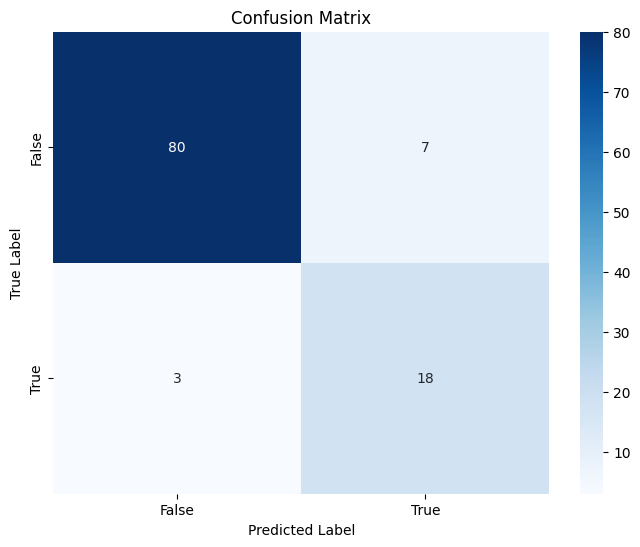

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

cm = confusion_matrix(end_result['truth'], end_result['pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [80]:
print(classification_report(end_result['truth'], end_result['pred']))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        87
           1       0.72      0.86      0.78        21

    accuracy                           0.91       108
   macro avg       0.84      0.89      0.86       108
weighted avg       0.92      0.91      0.91       108

